This notebook contains the code for generating final charts and tables for experiments

1 - Single run with 10.000 FM passes for all algorithms

2 - 25 runs with fixed CPU time of 450 seconds each for all algorithms.

In [2]:
import utils
import numpy as np
import pandas as pd
from IPython.display import HTML
import matplotlib.pyplot as plt
import ils_adaptive as ila

Experiment 1 - Single run with 10.000 FM passes for all algorithms

In [10]:
mls_single_file = "pckl/final_results/2025-03-31_17-58-36_MLS-10000-best_cut_26-time_469.947.pkl"
ils_ada_single_file = "pckl/final_results/2025-04-03_15-14-03_ILS-ADA-p0.001_a0.1_b0.2_sFalse-st0.6-st40-runs_1-max_iterations_10000-best_cut_8-time_439.576.pkl"
ils_single_file = "pckl/final_results/2025-03-31_16-37-48_ILS-10000-mutation_70-best_cut_9-time_449.797.pkl"
gls_single_file = "pckl/final_results/20250331-173550_GLS-10000-pop_size_50.pkl"

mls_single_data = utils.load_pickle(mls_single_file)[0]
row1 = ['MLS', mls_single_data["best_cut_size"], mls_single_data["time_elapsed"]]
#pmin=0.001, a=0.6, b=0.2, threshold=0.6, st=30
ils_ada_single_data = utils.load_pickle(ils_ada_single_file)[0]
row2 = ['ILS-ADA', ils_ada_single_data["best_cut_size"], ils_ada_single_data["time_elapsed"]]

ils_single_data = utils.load_pickle(ils_single_file)[0]
row4 = ['ILS', ils_single_data["best_cut_size"], ils_single_data["time_elapsed"]]

gls_single_data = utils.load_pickle(gls_single_file)
row5 = ['GLS', gls_single_data["cut_sizes"][0], gls_single_data["run_times"][0]]

columns = ["Algorithm", "Best Cut", "Time (s)"]
data = [row1, row2, row4, row5]
df = pd.DataFrame(data, columns=columns)
#df = df.set_index("Algorithm")
df = df.sort_values(by="Best Cut", ascending=True)
#df = df.round(3)

styled_df = df.style.set_properties(**{'text-align': 'center'})
styled_df = styled_df.format(precision=3)
styled_df = styled_df.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
styled_df = styled_df.hide(axis='index')
html_table = styled_df.to_html()
HTML(html_table)




Algorithm,Best Cut,Time (s)
ILS-ADA,8,439.570
ILS,9,449.797
GLS,9,437.171
MLS,26,469.947


Experiment 2 - 25 runs with fixed CPU time of 450 seconds each for all algorithms.

/var/folders/lm/8m47310n0sbc6d8tdlxcd8pw0000gn/T/ipykernel_24044/201010940.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cut_sizes, labels=algorithms)


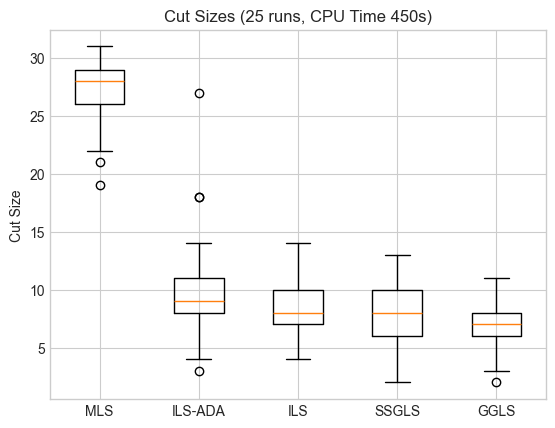

In [11]:
mls_results_file = "pckl/final_results/2025-03-31_21-09-02_MLS-CPU-TIME-runs_25-cpu_time_450-best_cut_27.16-time_440.404.pkl"
ils_results_file = "pckl/final_results/2025-03-31_20-04-51_ILS-CPU_TIME-runs_25-max_cpu450-best_cut_8.92-time_450.08.pkl"
gls_results_file = "pckl/final_results/20250331-204030_GLS-25-pop_size_50-CPU_TIME_450.pkl"
ils_ada_folder = "pckl/final_results/ils-ada-25"
ggls_results_file = "pckl/sequential_10s_results/ggls_sequential_25runs_450s_pop50.pkl" 

#load the MLS results
mls_data = utils.load_pickle(mls_results_file) 
mls_stats = mls_data[-1]
mls_data = mls_data[:-1] #drop the last row which is a summary

mls = pd.DataFrame(mls_data)
cut_sizes_mls = list(mls['best_cut_size'])

#load the ILS results
ils_data = utils.load_pickle(ils_results_file)[:-1] 
ils = pd.DataFrame(ils_data)
cut_sizes_ils = list(ils['best_cut_size'])

#load the ILS-ADA results
ilsa_data = ila._load_results_from_folder(ils_ada_folder)
#ilsa_data = ilsa_data[:-1] #drop the last row which is a summary
rows = []
for i in range(len(ilsa_data)):
    rows.append(ilsa_data[i][0])
ils_ada = pd.DataFrame(rows)

#{'p_min': 0.0001, 'alpha': 0.4, 'beta': 0.2, 'use_stage_weights': False}
cut_sizes_ils_ada = list(ils_ada['best_cut_size'])

#load the GLS results
gls = utils.load_pickle(gls_results_file)
cut_sizes_gls = gls['cut_sizes']
#load the GGLS results 
cut_sizes_ggls = utils.load_pickle(ggls_results_file)

algorithms = ['MLS','ILS-ADA','ILS', 'SSGLS', "GGLS"]
cut_sizes = [cut_sizes_mls, cut_sizes_ils_ada, cut_sizes_ils, cut_sizes_gls, cut_sizes_ggls ]

#box plots
plt.boxplot(cut_sizes, labels=algorithms)
plt.title("Cut Sizes (25 runs, CPU Time 450s)")
plt.ylabel("Cut Size")
plt.style.use('seaborn-v0_8-whitegrid')  # or 'classic'

plt.show()


Statistical significance tests.

In [12]:
#Perform the statistical tests. You need to run the previous code block to get the cut sizes.
data = np.full((len(algorithms), len(algorithms)), np.nan)
for i in range(len(algorithms)):
    for j in range(len(algorithms)):
        if i == j:
            data[i][j] = np.float64(1)
        else:
            data[i][j] = utils.perform_mann_whitney_u_test(cut_sizes[i], cut_sizes[j])[1]

columns = algorithms
index = algorithms
df = pd.DataFrame(data, columns=columns, index=index)
styled_df = df.style.set_properties(**{'text-align': 'center'})
styled_df = styled_df.format(precision=4)
styled_df = styled_df.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
html_table = styled_df.to_html()
HTML(html_table)

,MLS,ILS-ADA,ILS,SSGLS,GGLS
MLS,1.0000,0.0000,0.0000,0.0000,0.0000
ILS-ADA,0.0000,1.0000,0.4628,0.1324,0.0015
ILS,0.0000,0.4628,1.0000,0.3275,0.0036
SSGLS,0.0000,0.1324,0.3275,1.0000,0.0587
GGLS,0.0000,0.0015,0.0036,0.0587,1.0000


Results summary table

In [13]:
#Generate the results table.
mls_best = min(cut_sizes_mls)
mean_mls = np.mean(cut_sizes_mls)
mls_median = np.median(cut_sizes_mls)
stdev_mls = np.std(cut_sizes_mls)

ils_best = min(cut_sizes_ils)
mean_ils = np.mean(cut_sizes_ils)
ils_median = np.median(cut_sizes_ils)
stdev_ils = np.std(cut_sizes_ils)

ils_ada_best = min(cut_sizes_ils_ada)
mean_ils_ada = np.mean(cut_sizes_ils_ada)
ils_ada_median = np.median(cut_sizes_ils_ada)
stdev_ils_ada = np.std(cut_sizes_ils_ada)

gls_best = min(cut_sizes_gls)
mean_gls = np.mean(cut_sizes_gls)
gls_median = np.median(cut_sizes_gls)
stdev_gls = np.std(cut_sizes_gls)

ggls_best = min(cut_sizes_ggls)
mean_ggls = np.mean(cut_sizes_ggls)
ggls_median = np.median(cut_sizes_ggls)
stdev_ggls = np.std(cut_sizes_ggls)


columns = ['Algorithm', 'Best Cut', 'Mean', 'Median', 'Std Dev']
res_data = []
res_data.append(['MLS', mls_best, mean_mls, mls_median, stdev_mls])
res_data.append(['ILS-ADA', ils_ada_best, mean_ils_ada, ils_ada_median, stdev_ils_ada])
res_data.append(['ILS', ils_best, mean_ils, ils_median, stdev_ils])
res_data.append(['GLS', gls_best, mean_gls, gls_median, stdev_gls])
res_data.append(['GGLS', ggls_best, mean_ggls, ggls_median, stdev_ggls])
df = pd.DataFrame(res_data, columns=columns)
styled_df = df.style.set_properties(**{'text-align': 'center'})
styled_df = styled_df.format(precision=2)
styled_df = styled_df.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
styled_df = styled_df.hide(axis='index')
html_table = styled_df.to_html()
HTML(html_table)

Algorithm,Best Cut,Mean,Median,Std Dev
MLS,19,27.16,28.00,3.06
ILS-ADA,3,10.12,9.00,4.91
ILS,4,8.92,8.00,2.58
GLS,2,8.00,8.00,2.43
GGLS,2,6.72,7.00,2.09
